In [ ]:
%pip install tensorflow


In [ ]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS , 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
draw_landmarks(frame, results)

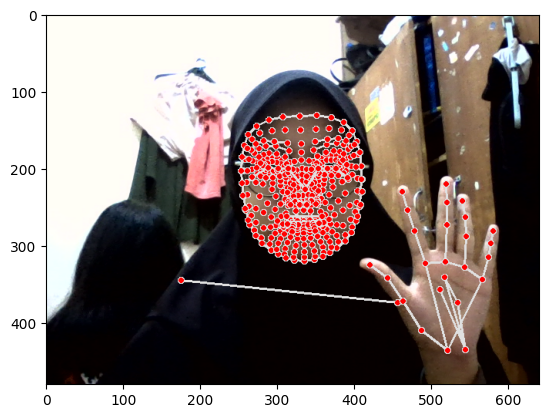

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [9]:
len(results.face_landmarks.landmark)

468

In [10]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [11]:
def extract_keypoints(res):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) 

In [12]:
result_test = extract_keypoints(results)
result_test.shape

(1662,)

In [14]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['A']) #siapa, nama, kamu, aku, bermain 

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [15]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [16]:
#Collect Dataset (Numpy Array)
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(5000) # <--- Ini adalah timer sleep yang mengatur delay 2000 ms (2 detik)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [17]:
cap.release()
cv2.destroyAllWindows()

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [19]:
label_map = {label:num for num, label in enumerate(actions)}

In [20]:
label_map

{'A': 0}

In [21]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [22]:
tf.random.set_seed(42)

In [23]:
X = np.array(sequences)

In [24]:
y = to_categorical(labels).astype(int)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
y_test.shape

(2, 1)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import TensorBoard

In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [28]:
'''
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
'''
'''
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, X.shape[2])))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
'''

'''
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, X.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(actions.shape[0], activation='softmax'))
'''

model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(30, X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(30, X.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(256, return_sequences=True, activation='relu')))
model.add(Dropout(0.3)) 
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(1, activation='softmax'))  # Jumlah kelas = 5

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 64)              │         319,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 14, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 14, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,228,161 (8.50 MB)

 Trainable params: 2,226,113 (8.49 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [30]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [31]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback]) #paling optimal di epoch = 500

Epoch 1/500


C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Ep

In [34]:
res = model.predict(X_test)
res

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (2, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.],
       [1.]], dtype=float32)

In [35]:
actions[np.argmax(res[0])]

'A'

In [36]:
actions[np.argmax(y_test[0])]

'A'

In [31]:
model.save('action.h5')

In [ ]:
del model

In [32]:
model.load_weights('action.h5')

In [37]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [38]:
yhat = model.predict(X_test)
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


array([[1.],
       [1.]], dtype=float32)

In [39]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [38]:
mcm = multilabel_confusion_matrix(ytrue, yhat)

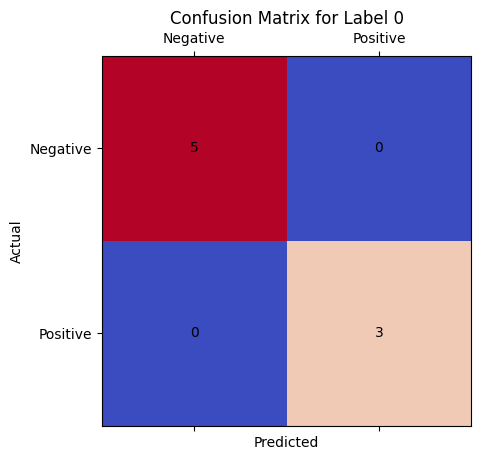

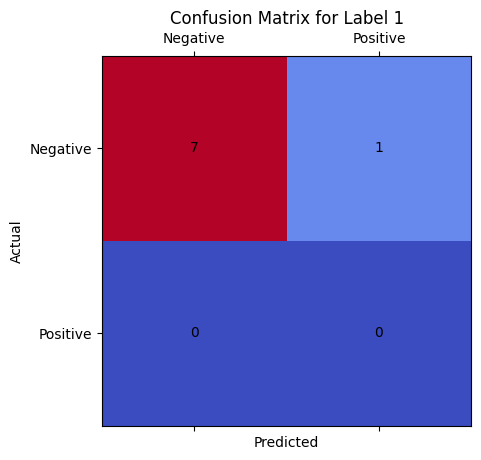

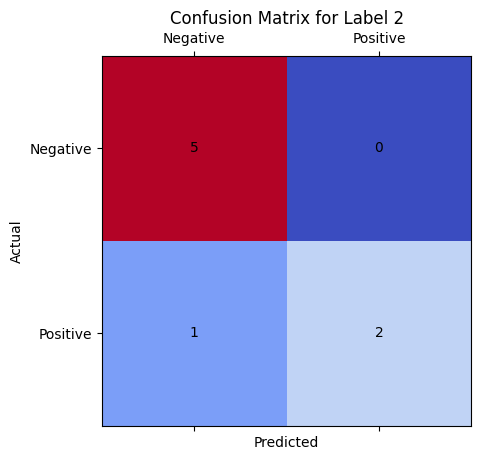

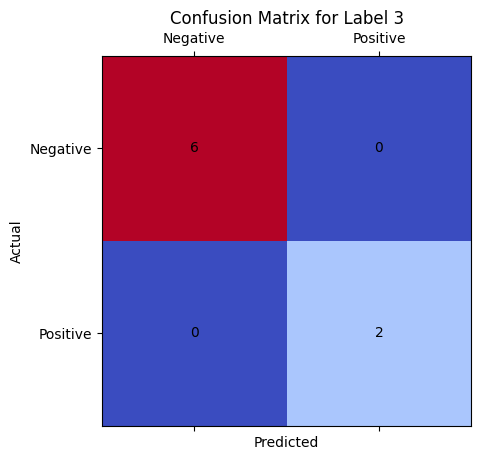

In [39]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(conf_matrix, label_index):
    fig, ax = plt.subplots()
    ax.matshow(conf_matrix, cmap='coolwarm')  # Pilih colormap yang sesuai
    
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix for Label {label_index}')
    plt.show()

# Plot confusion matrix untuk setiap label
for idx, matrix in enumerate(mcm):
    plot_confusion_matrix(matrix, idx)


In [40]:
accuracy_score(ytrue, yhat)


1.0

In [41]:
#colors = [(245,117,16), (117,245,16), (16,117,245), (255,255,153), (153,255,153)]
colors = [(245,117,16)] #kepentingan demo
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [44]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.35

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#        sequence.insert(0,keypoints)
#        sequence = sequence[:30]

        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


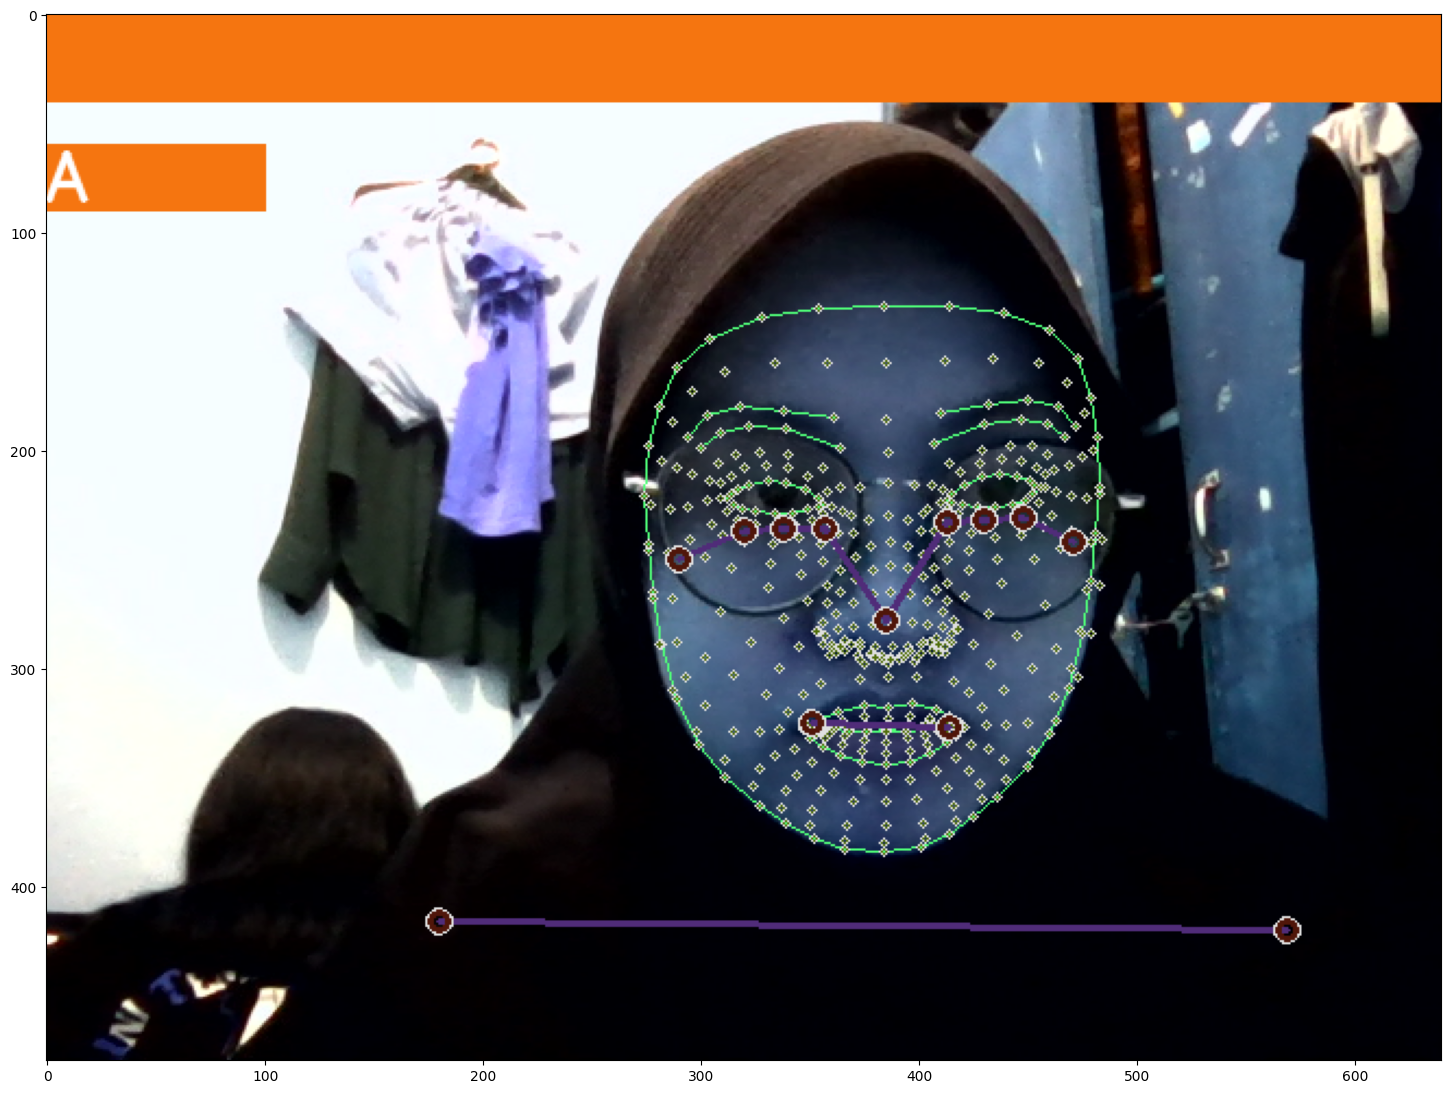

In [45]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [46]:
len(sequence)


9

In [47]:
sequence.append('def')


In [48]:
sequence.reverse()


In [49]:
sequence[-30:]


['def',
 array([ 0.60286731,  0.5802483 , -2.08120131, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60356498,  0.58391166, -2.08730078, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60882461,  0.58495176, -2.06373334, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.6121642 ,  0.58648217, -2.09479594, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.61589509,  0.58892733, -1.86829257, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.61802942,  0.58776957, -1.91371286, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.61766964,  0.57850343, -1.94117451, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.61454988,  0.55997556, -1.92098212, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60747552,  0.52682674, -1.90191245, ...,  0.        ,
         0.        ,  0.        ])]

In [50]:
cap.release()
cv2.destroyAllWindows()

In [51]:
res[np.argmax(res)] > threshold


True

In [52]:
(num_sequences,30,1662)


NameError: name 'num_sequences' is not defined

In [53]:
model.predict(np.expand_dims(X_test[0], axis=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


array([[1.]], dtype=float32)